In [30]:
import os
#import _pickle as cPickle
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils
#from data_utils.py import load_CIFAR10
from keras.utils import to_categorical
params = {}
params['batch_size'] = 25
params['num_epochs'] = 100
params['learning_rate'] = 1
params['activation'] = 'relu'
params['optimizer'] = 'sgd'
params['layers'] = [5, 2, 3, 4]
params['output_dim'] = 10
params['input_dim'] = 32*32*3
params['lr_decay'] = 0.5

In [25]:
def loadData():
    
    num_classes = 10

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    
    Y_train = keras.utils.to_categorical(Y_train, num_classes)
    Y_test = keras.utils.to_categorical(Y_test, num_classes)
    
    num_rows = X_train.shape[1]
    num_cols = X_train.shape[2]
    num_channels = X_train.shape[3]
    input_dims = num_rows*num_cols*num_channels 
    print(X_train.shape)
    
    #X_train = X_train.reshape(X_train.shape[0], input_dims)
    #X_test = X_test.reshape(X_test.shape[0], input_dims)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
                          
    return X_train, Y_train, X_test, Y_test

In [26]:
X_train, Y_train, X_test, Y_test = loadData()
print(X_train.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)


In [27]:
print("mean before normalization:", np.mean(X_train))
print("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)
for i in range(3):
    mean[i] = np.mean(X_train[:,i,:,:])
    std[i] = np.std(X_train[:,i,:,:])
    
for i in range(3):
    newX_train[:,i,:,:] = X_train[:,i,:,:] - mean[i]
    newX_train[:,i,:,:] = newX_train[:,i,:,:] / std[i]
    newX_test[:,i,:,:] = X_test[:,i,:,:] - mean[i]
    newX_test[:,i,:,:] = newX_test[:,i,:,:] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print("mean after normalization:", np.mean(X_train))
print("std after normalization:", np.std(X_train))

mean before normalization: 120.707
std before normalization: 64.15
mean after normalization: 0.906249997786
std after normalization: 0.422742165263


In [21]:
num_classes = 10
data_mean = np.mean(X_train)
data_std_dev = np.std(X_train)
print(data_mean, data_std_dev)

0.906249997786 0.422742165263


# Build the CNN

In [28]:
def build_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((2,2)), input_shape=(32,32,3) ))
    print(X_train.shape)
    model.add(Convolution2D(200, 5, 5,                                    #-- 200 outputs (200 filters), 5x5 convolution kernel
                            border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Convolution2D(200,5,5))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Flatten()) 
    model.add(Dense(384))
    model.add(BatchNormalization())              #-- 120 outputs fully connected layer
    model.add(Activation('relu'))                                       #-- ReLU non-linearity 
    model.add(Dense(192))                                                #-- 84 outputs fully connected layer
    model.add(BatchNormalization())
    model.add(Activation('relu'))                                       #-- ReLU non-linearity 
    model.add(Dense(num_classes))                                       #-- 10 outputs fully connected layer (one for each class)
    model.add(Activation('softmax'))
    return model

# randX, randY

In [12]:
np.random.seed(12345)
randX = data_std_dev*np.random.randn(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3]) + data_mean
corrupt_prob = 1.0
labels = np.argmax(Y_train,1)
mask = np.random.rand(len(labels)) <= corrupt_prob
rnd_labels = np.random.choice(num_classes, mask.sum())
labels[mask] = rnd_labels
# we need to explicitly cast the labels from npy.int64 to
# builtin int type, otherwise pytorch will fail...
randY = [int(x) for x in labels]
randY = to_categorical(randY)

## Train Cifar10

In [31]:
sgd = SGD(lr=params['learning_rate'])
preds = np.zeros((1000))

model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    #start = tim
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=100)
y_hat = model.predict(X_train)
#preds += y_hat[np.arange(1000), np.argmax(Y_train[:1000],1)]
    #print(preds)
    

#lis_cifar = preds/100.0
# inp = model.input 
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
# test = X_train[:1000]
# layer_outs = [func([test, 1.]) for func in functors]
# index = np.argmax(Y_train[:1000], 1)
# lis_cifar =  layer_outs[-1][0][np.arange(len(index)), index]
#plt.plot(sorted(lis_cifar))
#plt.show()

(50000, 32, 32, 3)


/Users/NikithaShravan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5), padding="valid")`
  
/Users/NikithaShravan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5))`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100


KeyboardInterrupt: 

## Train randX

(50000, 32, 32, 3)


/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5), padding="valid")`
  
/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5))`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/1
 - 19s - loss: 2.6347 - acc: 0.1018
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.6964 - acc: 0.1000
(50000, 32, 32, 3)
Epoch 1/1
 - 18s - loss: 2.6785 - acc: 0.1000
(50000, 32, 32, 3)
Epoch 1/1
 - 18s - loss: 2.7728 - acc: 0.1003
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.6997 - acc: 0.1031
(50000, 32, 32, 3)
Epoch 1/1
 - 18s - loss: 2.6389 - acc: 0.0986
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.7132 - acc: 0.1018
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.8268 - acc: 0.0991
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.7901 - acc: 0.0989
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 2.6741 - acc: 0.1026
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 2.6672 - acc: 0.0989
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 2.7548 - acc: 0.1006
(50000, 32, 32, 3)
Epoch 1/1
 - 19s - loss: 2.6466 - acc: 0.1009
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 2.6479 - acc: 0.1000
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 2.9239 - acc: 0.1002
(50000, 32, 32, 3)
Epoch 1/1
 - 20s - loss: 

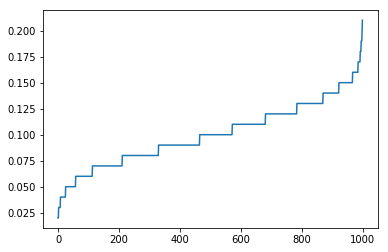

In [23]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
preds = np.zeros((1000))
for i in range(100):
    model = build_model()
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    history = model.fit(x = randX, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=1)
    y_hat = np.argmax(model.predict(randX[:1000]),1)
    #print(y_hat)
    preds += y_hat == np.argmax(Y_train[:1000],1)
    #print(preds)
    

lis_randx = preds/100.0
# inp = model.input 
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
# test = X_train[:1000]
# layer_outs = [func([test, 1.]) for func in functors]
# index = np.argmax(Y_train[:1000], 1)
# lis_cifar =  layer_outs[-1][0][np.arange(len(index)), index]
plt.plot(sorted(lis_randx))
plt.show()


## Train randY

In [14]:
model = build_model()
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y=randY, verbose=2, batch_size=params['batch_size'], epochs=1)
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

# Testing
test = X_train[:1000]
layer_outs = [func([test, 1.]) for func in functors]
index = np.argmax(randY[:1000], 1)
lis_randy =  layer_outs[-1][0][np.arange(len(index)), index]

(50000, 32, 32, 3)


/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5), padding="valid")`
  
/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5))`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/1
 - 8s - loss: 2.6250 - acc: 0.0972


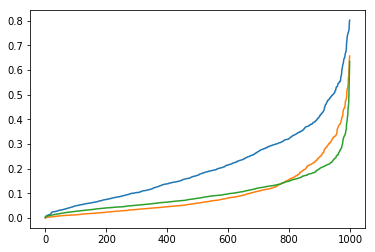

In [18]:
plt.plot(sorted(lis_cifar))
plt.plot(sorted(lis_randx))
plt.plot(sorted(lis_randy))
plt.show()